In [2]:
import os
import numpy as np
# set names to the paths because they're too long
data_path = 'hand_write_data/'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [3]:
def get_mnist_data(images_path, labels_path, num_images
, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
        # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
        # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [4]:
train_images, train_labels = get_mnist_data(
train_images_path, train_labels_path, 5000, shuffle=True)
test_images, test_labels = get_mnist_data(
test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(5000, 784) (5000,)
(10000, 784) (10000,)


In [5]:
from scipy import sparse

# Convert matrix to image
def get_image(image):
    return image.reshape(28, 28)

def convert_labels(y, C):
    Y = sparse.coo_matrix((np.ones_like(y),(y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

In [41]:
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T),
axis = 0)

Y_train = convert_labels(train_labels, 10)

X_test = np.concatenate((np.ones((1, test_images.shape[0])), test_images.T),
axis = 0)
y_test = test_labels


(785, 5000)


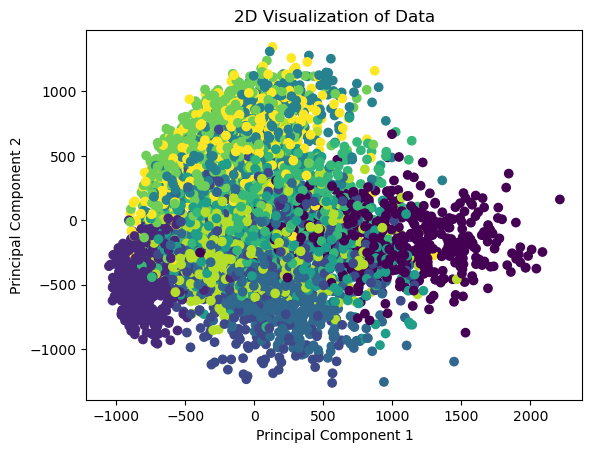

In [42]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Áp dụng PCA để giảm chiều dữ liệu về 100 chiều
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(np.transpose(X_train))
X_test_pca = pca.transform(np.transpose(X_test))

# Hiển thị biểu đồ scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Data')
plt.show()

Accuracy on testing data: 0.9111111111111111


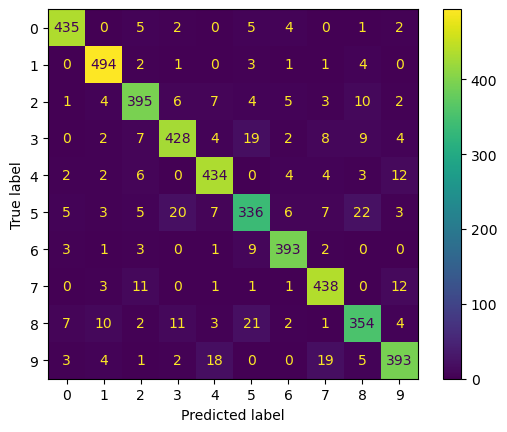

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = np.concatenate((train_images, test_images), axis=0)
y = np.concatenate((train_labels, test_labels), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=65)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Xây dựng mô hình hồi quy logistic
model = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000)

# Huấn luyện mô hình trên dữ liệu đã được giảm chiều
model.fit(X_train_pca, y_train)

# Dự đoán nhãn cho dữ liệu test đã được giảm chiều
y_pred = model.predict(X_test_pca)

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing data:", accuracy)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Accuracy on testing data: 0.9388888888888889


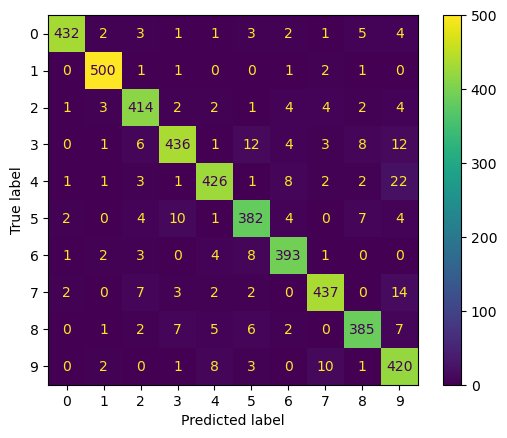

In [40]:
from sklearn.neural_network import MLPClassifier

# Xây dựng mô hình hồi quy ann
ann = MLPClassifier()
ann.fit(X_train, y_train)

# Huấn luyện mô hình trên dữ liệu đã được giảm chiều
ann.fit(X_train_pca, y_train)

# Dự đoán nhãn cho dữ liệu test đã được giảm chiều
y_pred = ann.predict(X_test_pca)

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing data:", accuracy)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()